# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复加载 OpenMP



# b. MNIST Data Loader

In [2]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 1024
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. PixelCNN**


# a. Training Function

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            # loss = bce(pred, tgt)
            tgt = tgt.squeeze(1).long()
            loss = F.cross_entropy(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [49]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, c_in, c_out, kernel_size,stride, padding, mask_type):
        super().__init__(c_in, c_out, kernel_size, stride, padding)
        mask = torch.zeros_like(self.weight)
        h, w = self.kernel_size
        center_h, center_w = h // 2, w // 2
        if mask_type == 'A':
            mask[:, :, :center_h, :] = 1
            mask[:, :, center_h, :center_w] = 1
        elif mask_type == 'B':
            mask[:, :, :center_h, :] = 1
            mask[:, :, center_h, :center_w+1] = 1
        
        self.register_buffer('mask', mask)
    def forward(self, x):
        # self.weight.data *= self.mask
        # return super().forward(x)
        masked_weight = self.weight * self.mask # 创建一个被掩码的权重副本
        return F.conv2d(x, masked_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    ##################


# c. Model

In [50]:
class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    def __init__(self):
        super().__init__()
        Type_A = MaskedConv2d(mask_type='A', in_channels = 1, out_channels = 32, kernel_size = 7, padding = 3, )
        Type_B =MaskedConv2d(mask_type='B', in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, )
        layers = []
        layers.append(Type_A)
        for _ in range(2):
            layers.append(torch.nn.ReLU())
            layers.append(Type_B)
        self.main_layer = nn.Sequential(*layers)
        self.out_layer = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 256, 1)
        )

    def forward(self, x):
        x = self.main_layer(x)
        x = self.out_layer(x)
        return x
    ##################

# d. Training

In [17]:
##################
### Problem 2(c): Training
epochs = 10
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)
##################


TypeError: MaskedConv2d.__init__() got an unexpected keyword argument 'in_channels'

# e. Evaluation (Reconstruction)

torch.Size([128, 1, 28, 28])


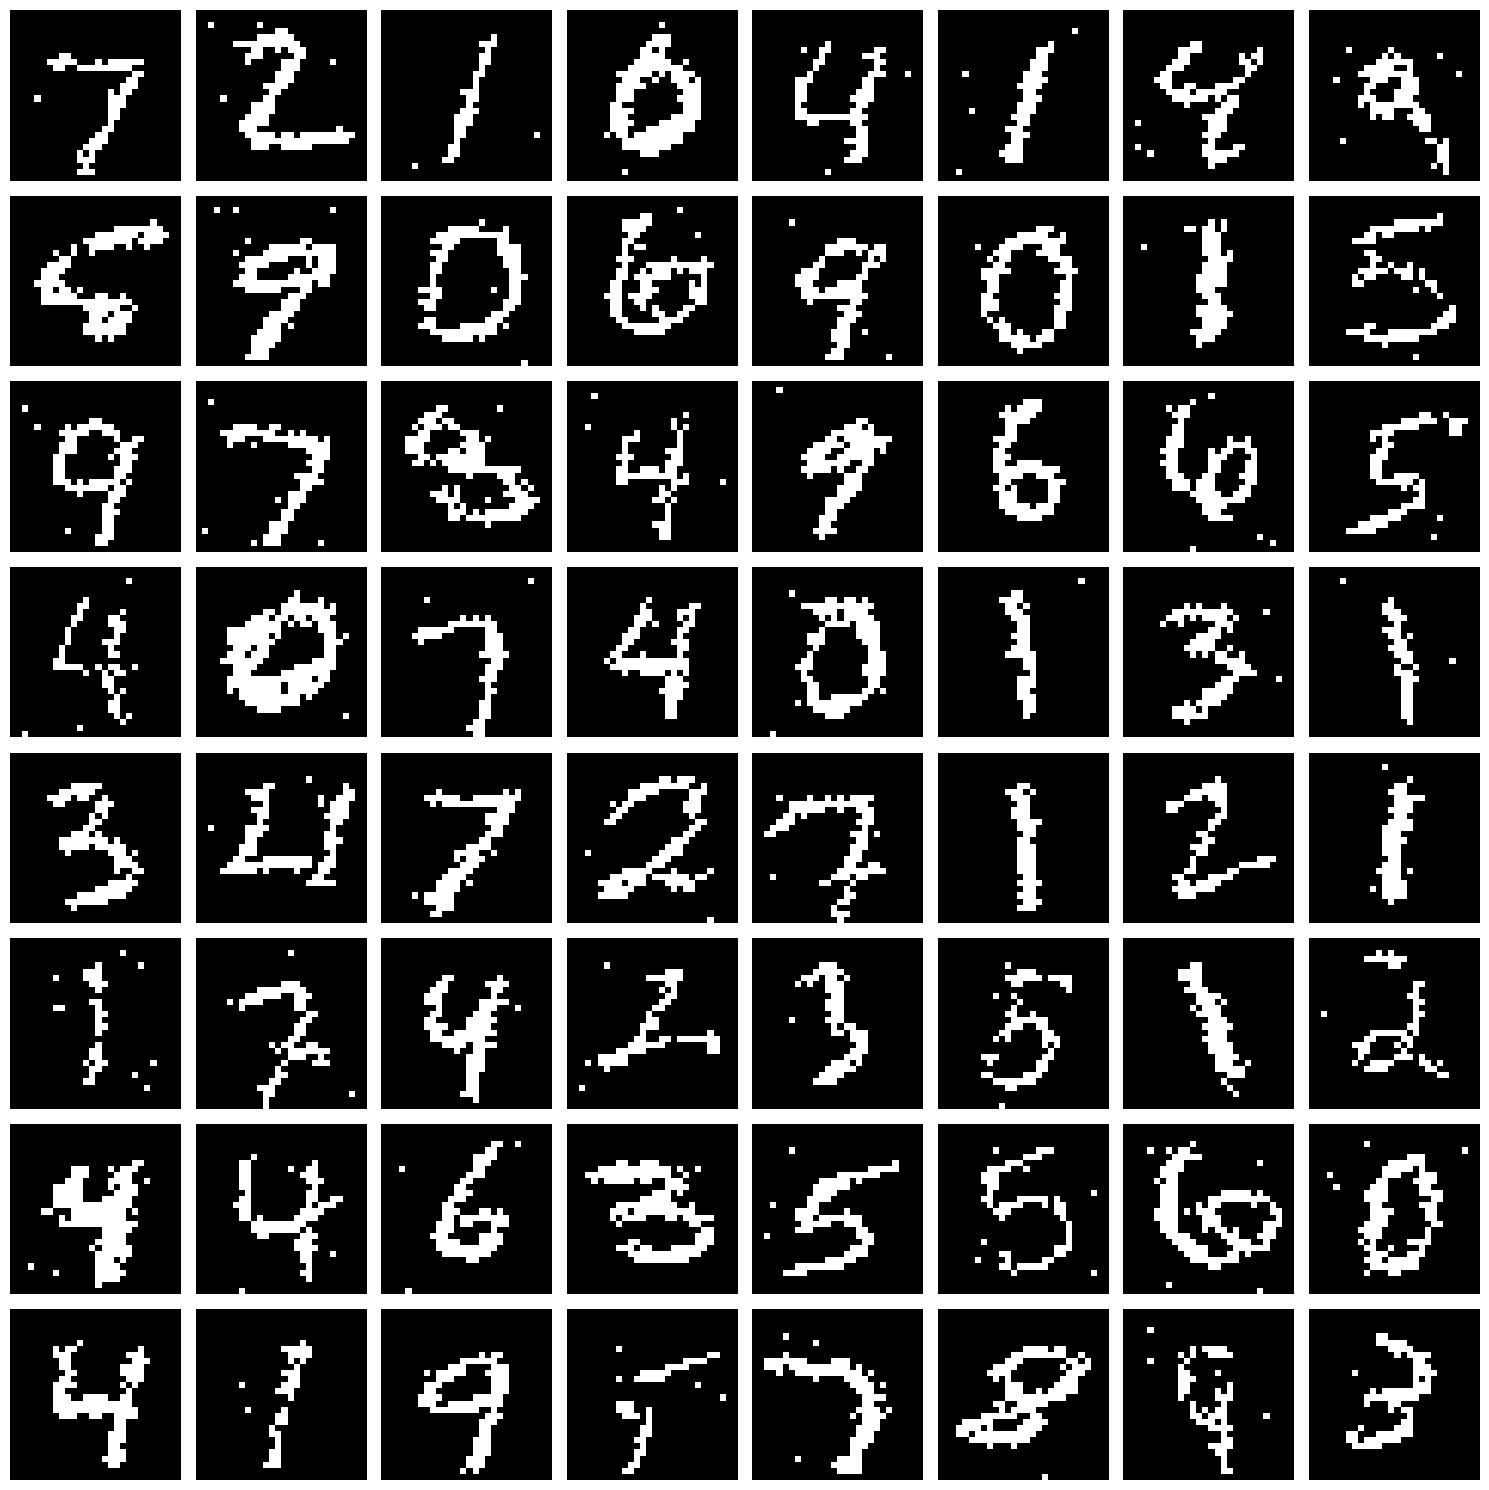

In [12]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)
      pred = F.softmax(pred, dim=1)

      probs_flat = pred.permute(0, 2, 3, 1).reshape(-1, pred.shape[1])
      
      # 对每个扁平化的像素采样一个值
      sampled_pixels_flat = torch.multinomial(probs_flat, 1) # 形状 (B*H*W, 1)
      
      # 将采样结果重塑回 (batch_size, H, W)
      sampled_pixels = sampled_pixels_flat.reshape(batch_size, H, W)
      reconstructed_images = sampled_pixels.float().unsqueeze(1) 
      pred = reconstructed_images
      break
print(pred.shape)
samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
# print(samples.shape)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample.squeeze(), cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

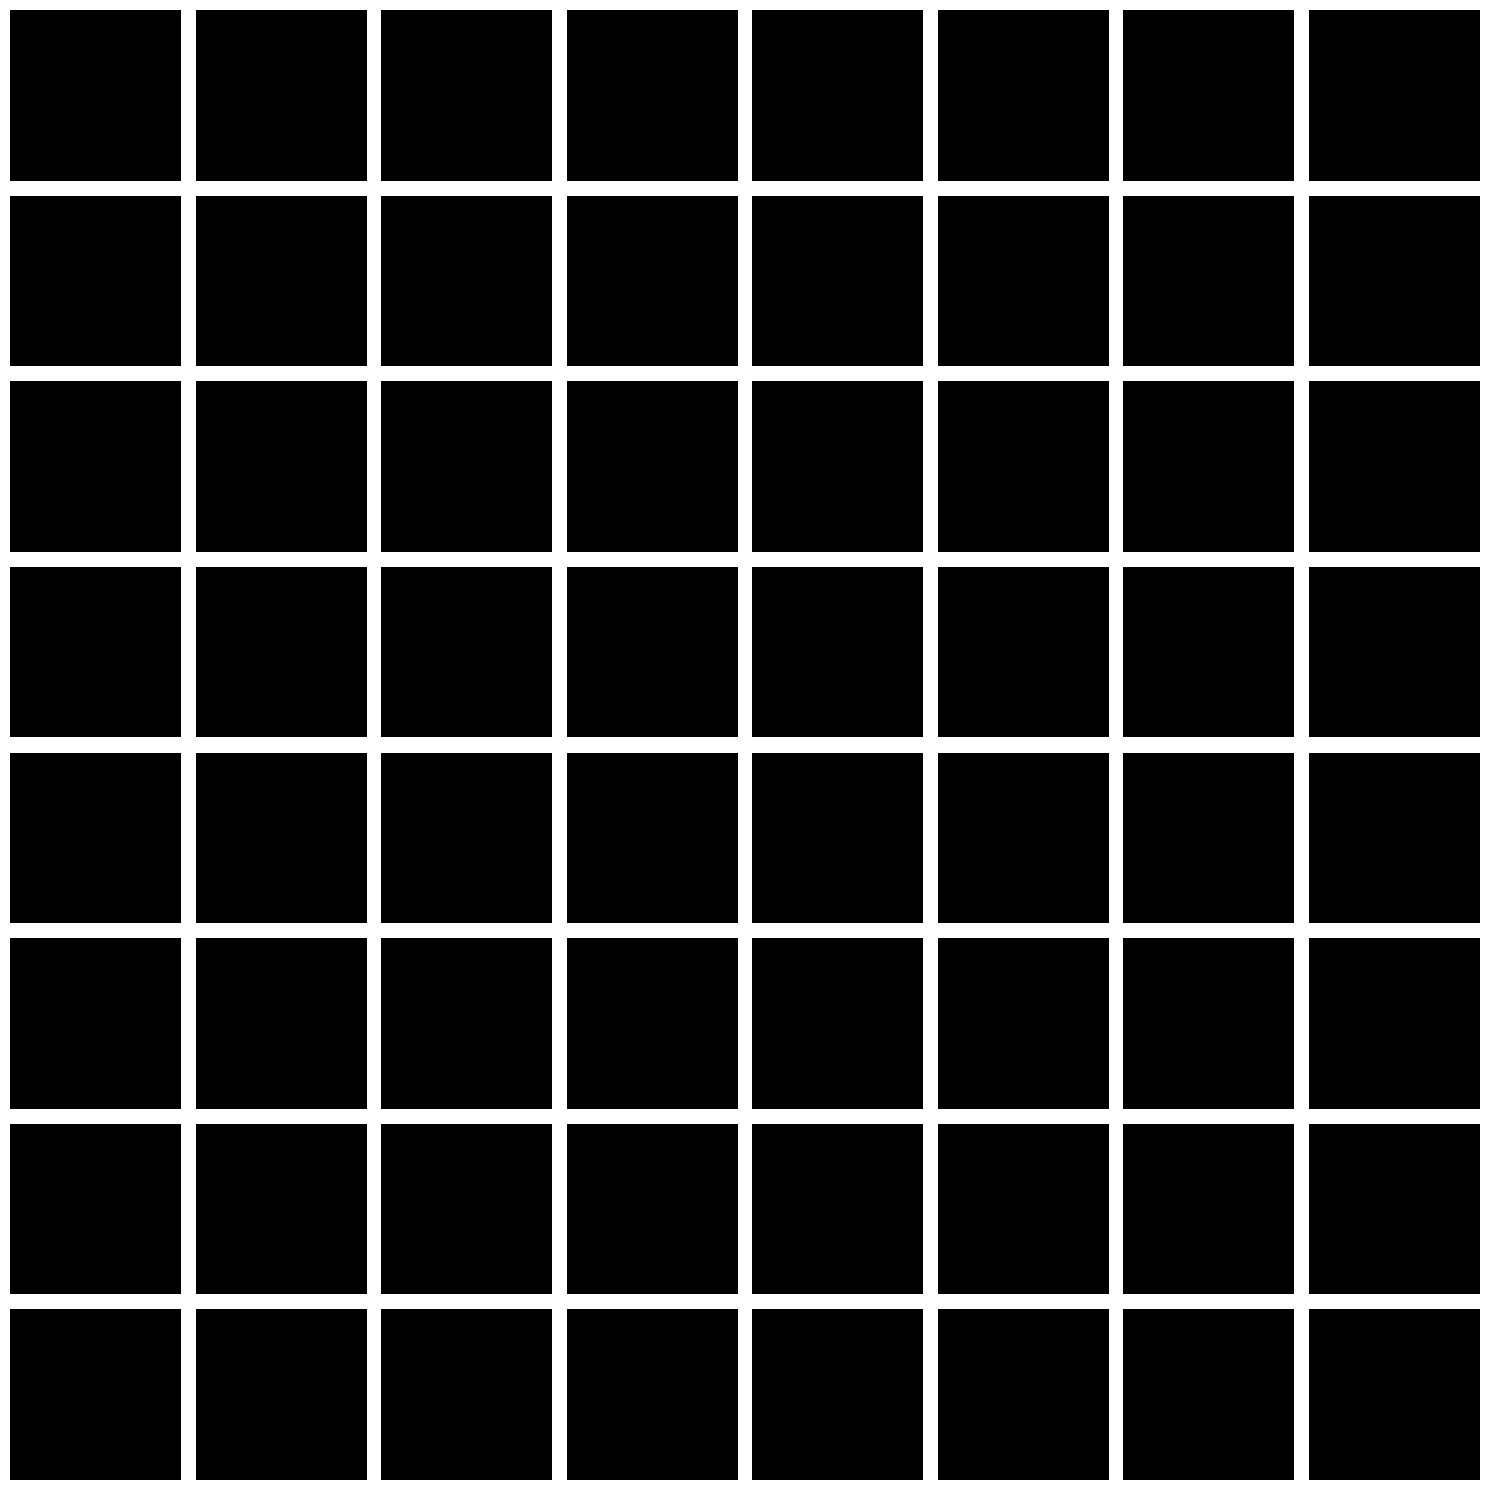

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 假设你的 PixelCNN 模型和 MaskedConv2d 已经定义并训练好了
# 并且模型已经加载到 device 上
# model.eval() # 确保模型处于评估模式

H, W = 28, 28
num_samples = 64 # 要生成的图像数量
num_pixel_values = 256 # 像素值范围 0-255

# 创建一个用于存储生成图像的空白张量
# 注意：这里是 (batch_size, 1, H, W) 因为 MNIST 是单通道
generated_images = torch.zeros(num_samples, 1, H, W).to(device)

with torch.no_grad():
    for i in range(H): # 遍历行
        for j in range(W): # 遍历列
            logits = model(generated_images) 
            pixel_logits = logits[:, :, i, j] # 形状是 (num_samples, 256)
            probs = F.softmax(pixel_logits, dim=1) # dim=1 是类别维度
            sampled_pixel_values = torch.multinomial(probs, 1) # 形状 (num_samples, 1)
            generated_images[:, 0, i, j] = sampled_pixel_values.float().squeeze(1)

samples_np = generated_images.detach().cpu().numpy().transpose(0, 2, 3, 1) # (N, H, W, C)

fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for k in range(num_samples):
    sample = samples_np[k]
    row, col = divmod(k, 8)
    axes[row, col].imshow(sample.squeeze(), cmap='gray', vmin=0, vmax=255) # squeeze for (H, W) for imshow
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [20]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)
            tgt = tgt.squeeze(1).long()
            # target_pixels = (images * 255).round().long().squeeze(1) # 先乘以255，四舍五入，再转为long，并移除通道维度
            # loss = F.cross_entropy(pred, target_pixels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [75]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(self, c_in, c_out, kernel_size, stride, padding, numclass, mask_type):
        super().__init__(c_in, c_out, kernel_size,stride, padding, mask_type)
        self.V = nn.Linear(numclass, 28*28)
    def forward(self, x, class_condition):
        conv_out = super().forward(x)
        conditional_bias = self.V(class_condition).view(-1, 1, 28, 28)
        out = conv_out + conditional_bias
        return out
    ##################


# c. Model

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假设 device 已经定义，例如 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConditionalPixelCNN(nn.Module):
    def __init__(self, num_input_c=1, num_inner_c=32, num_output_c=1, num_classes=10): # 添加 num_classes
        super().__init__()

        
        # 初始特征提取层 (浅层特征)
        # 第一个掩码卷积通常是 Type A，以确保严格的自回归
        self.initial_block = nn.ModuleList([
            ConditionalMaskedConv2d(num_input_c, num_inner_c, kernel_size=7, stride=1, padding=3, numclass=num_classes, mask_type='A'),
            nn.LeakyReLU(0.1) # 激活函数
        ])

        # 残差块网络
        self.mainbolck = []
        for i in range(4):
            self.mainbolck.append(ConditionalMaskedConv2d(num_inner_c, num_inner_c, kernel_size=3, stride=1, padding=1, numclass=num_classes, mask_type='B'),)            
            self.mainbolck.append(nn.ReLU())
        self.mainbolck = nn.ModuleList(self.mainbolck)
        # 最终的 1x1 卷积层 (通常是 Type B，用于捕获当前像素的信息)
        # self.final_block_0 = nn.ModuleList([
        #     ConditionalMaskedConv2d(num_inner_c, num_inner_c, kernel_size=1, stride=1, padding=0, numclass=num_classes, mask_type='B'),
        #     nn.LeakyReLU(0.1) # 激活函数
        # ])

        # 输出层 (另一个 1x1 卷积，Type B)
        self.output_layer = nn.ModuleList([
            ConditionalMaskedConv2d(num_inner_c, num_output_c, kernel_size=1, stride=1, padding=0, numclass=num_classes, mask_type='B'),
            nn.Sigmoid() # 用于二值图像或归一化概率
            # 如果是多分类 (如 256 灰度级)，这里可能是 nn.Conv2d(num_inner_c, num_output_c * num_bins, 1) + view + log_softmax
        ])
        print(self.initial_block)
        print(self.mainbolck)
        # print(self.final_block_0)
        print(self.output_layer)
        # 注意：这里不再包含 self.to(device)，请在模型实例化后调用 model.to(device)
    def forward(self, x, class_condition):
        # 浅层特征提取
        for layer in self.initial_block:
            if isinstance(layer, ConditionalMaskedConv2d):
                x = layer(x, class_condition)
            else:
                x = layer(x) # 例如 LeakyReLU

        # 外部残差连接
        residual_x = x # 保存 x 的副本用于残差连接
        for block in self.mainbolck:
            if isinstance(block, ConditionalMaskedConv2d):
                residual_x = block(residual_x, class_condition)
            else:
                residual_x = block(residual_x)
        x = x + residual_x # 将所有残差块处理后的结果加回到原始的浅层特征

        # 最终特征提取和输出
        # for layer in self.final_block_0:
        #     if isinstance(layer, ConditionalMaskedConv2d):
        #         x = layer(x, class_condition)
        #     else:
        #         x = layer(x)

        for layer in self.output_layer:
            if isinstance(layer, ConditionalMaskedConv2d):
                x = layer(x, class_condition)
            else:
                x = layer(x)

        return x

# d. Training

In [76]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


ModuleList(
  (0): ConditionalMaskedConv2d(
    1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)
    (V): Linear(in_features=10, out_features=784, bias=True)
  )
  (1): LeakyReLU(negative_slope=0.1)
)
ModuleList(
  (0): ConditionalMaskedConv2d(
    32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (V): Linear(in_features=10, out_features=784, bias=True)
  )
  (1): ReLU()
  (2): ConditionalMaskedConv2d(
    32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (V): Linear(in_features=10, out_features=784, bias=True)
  )
  (3): ReLU()
  (4): ConditionalMaskedConv2d(
    32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (V): Linear(in_features=10, out_features=784, bias=True)
  )
  (5): ReLU()
  (6): ConditionalMaskedConv2d(
    32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (V): Linear(in_features=10, out_features=784, bias=True)
  )
  (7): ReLU()
)
ModuleList(
  (0): ConditionalMaskedConv2d(
    32, 1, kernel_size=(1, 1), stride=(1,

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.3822



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.2004



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1409



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1116



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1011



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0962



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0936



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0918



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0905



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0894



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.0885



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.0877



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.0870



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.0866



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.0860



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.0854



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.0849



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.0848



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.0842



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.0839



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.0836



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.0833



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.0830



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.0827



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.0824



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.0823



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.0821



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.0818



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.0816



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.0813



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.0811



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.0811



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.0808



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.0808



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.0804



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.0805



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.0801



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.0800



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.0800



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.0798



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.0796



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.0796



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.0795



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.0793



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.0792



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.0792



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.0790



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.0790



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.0789



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.0787



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.0787



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.0784



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.0785



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.0784



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.0784



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.0783



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.0780



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.0780



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.0781



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.0780



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.0780



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.0777



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.0777



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.0778



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.0777



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.0775



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.0775



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.0775



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.0774



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.0774



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.0773



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.0772



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.0772



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.0772



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.0770



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.0770



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.0771



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.0770



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.0769



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.0769



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.0769



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.0767



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.0769



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.0767



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.0766



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.0768



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.0767



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.0765



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.0766



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.0764



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.0764



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.0765



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.0764



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.0765



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.0762



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.0762



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.0763



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.0763



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.0762



Batches:   0%|          | 0/59 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.0762



In [77]:
torch.save(model, 'PixelCNN_Condition.pt')

# e. Evaluation (Reconstruction)

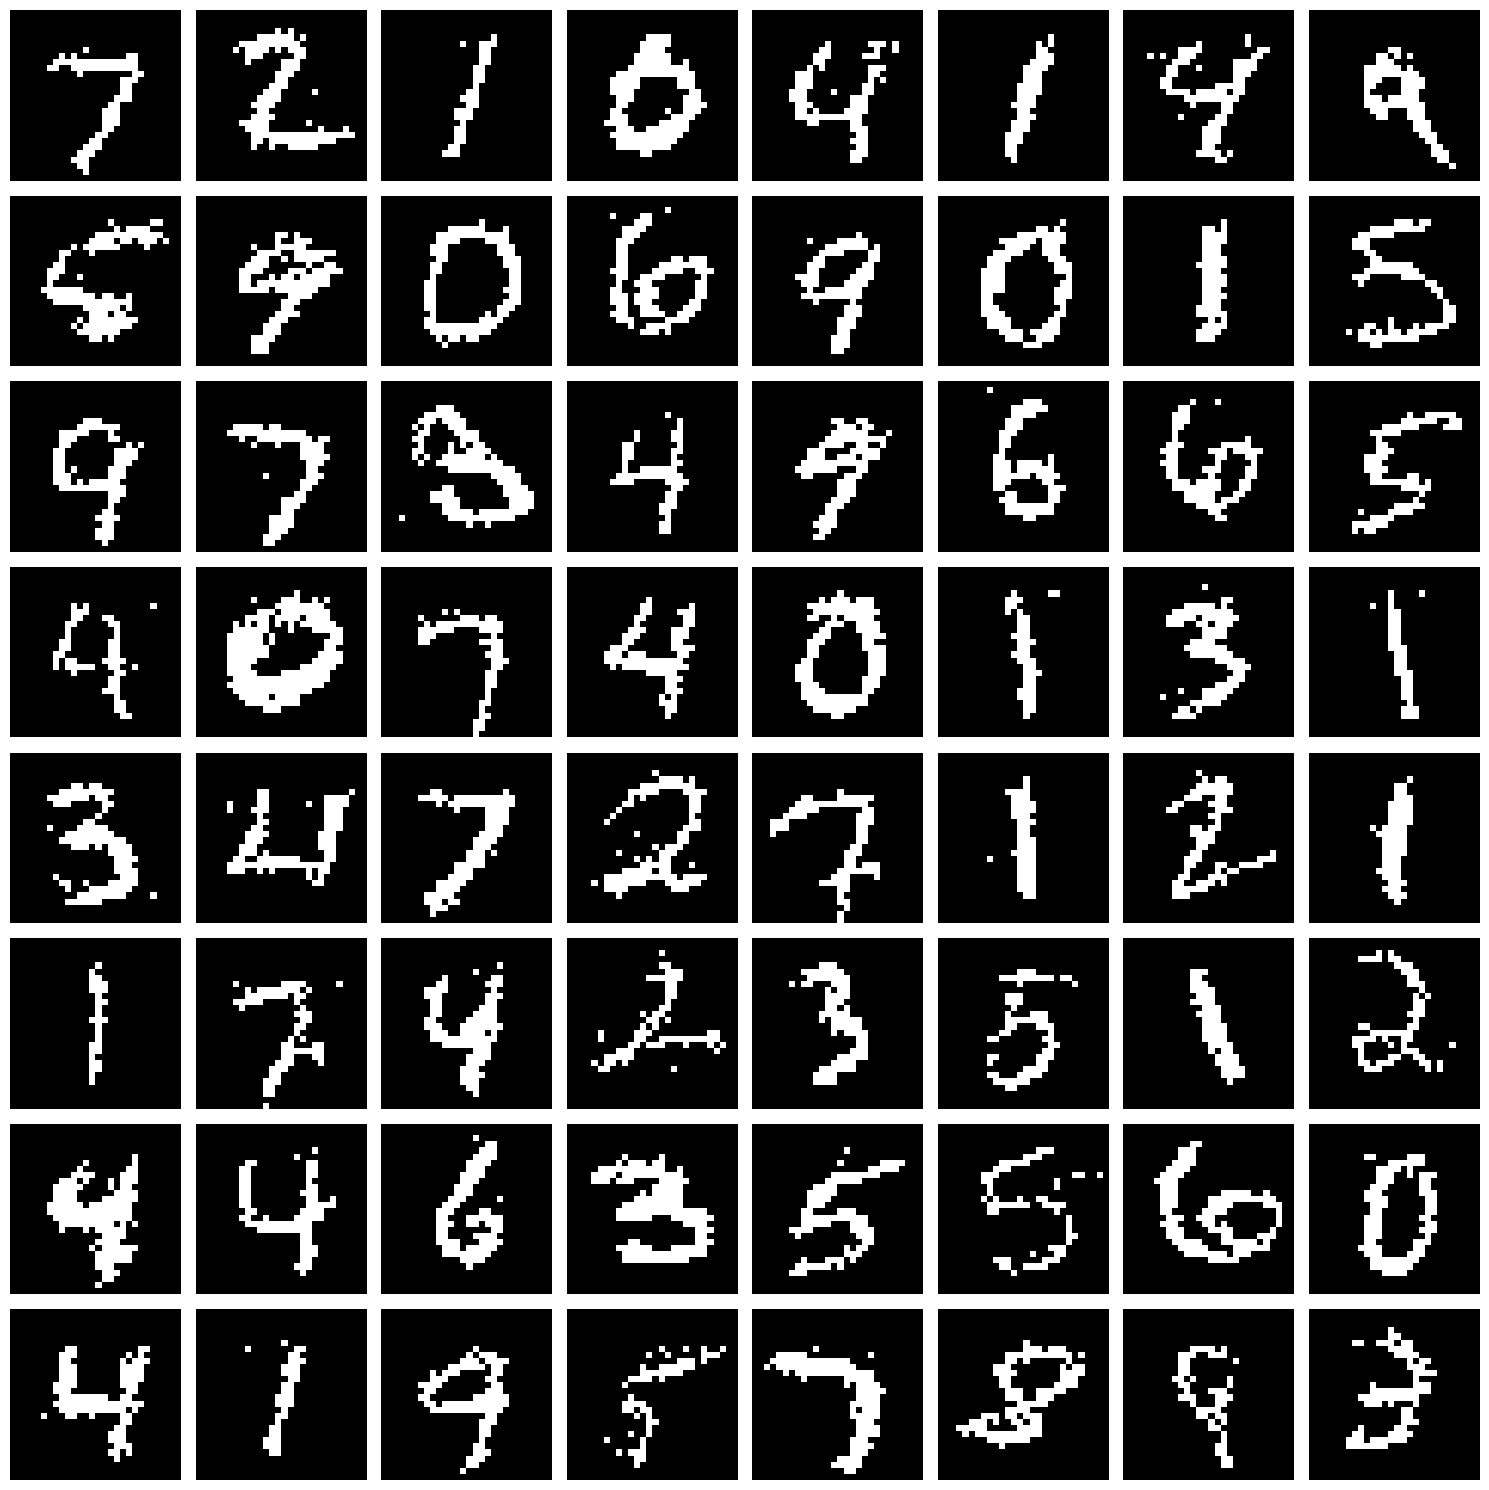

In [78]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

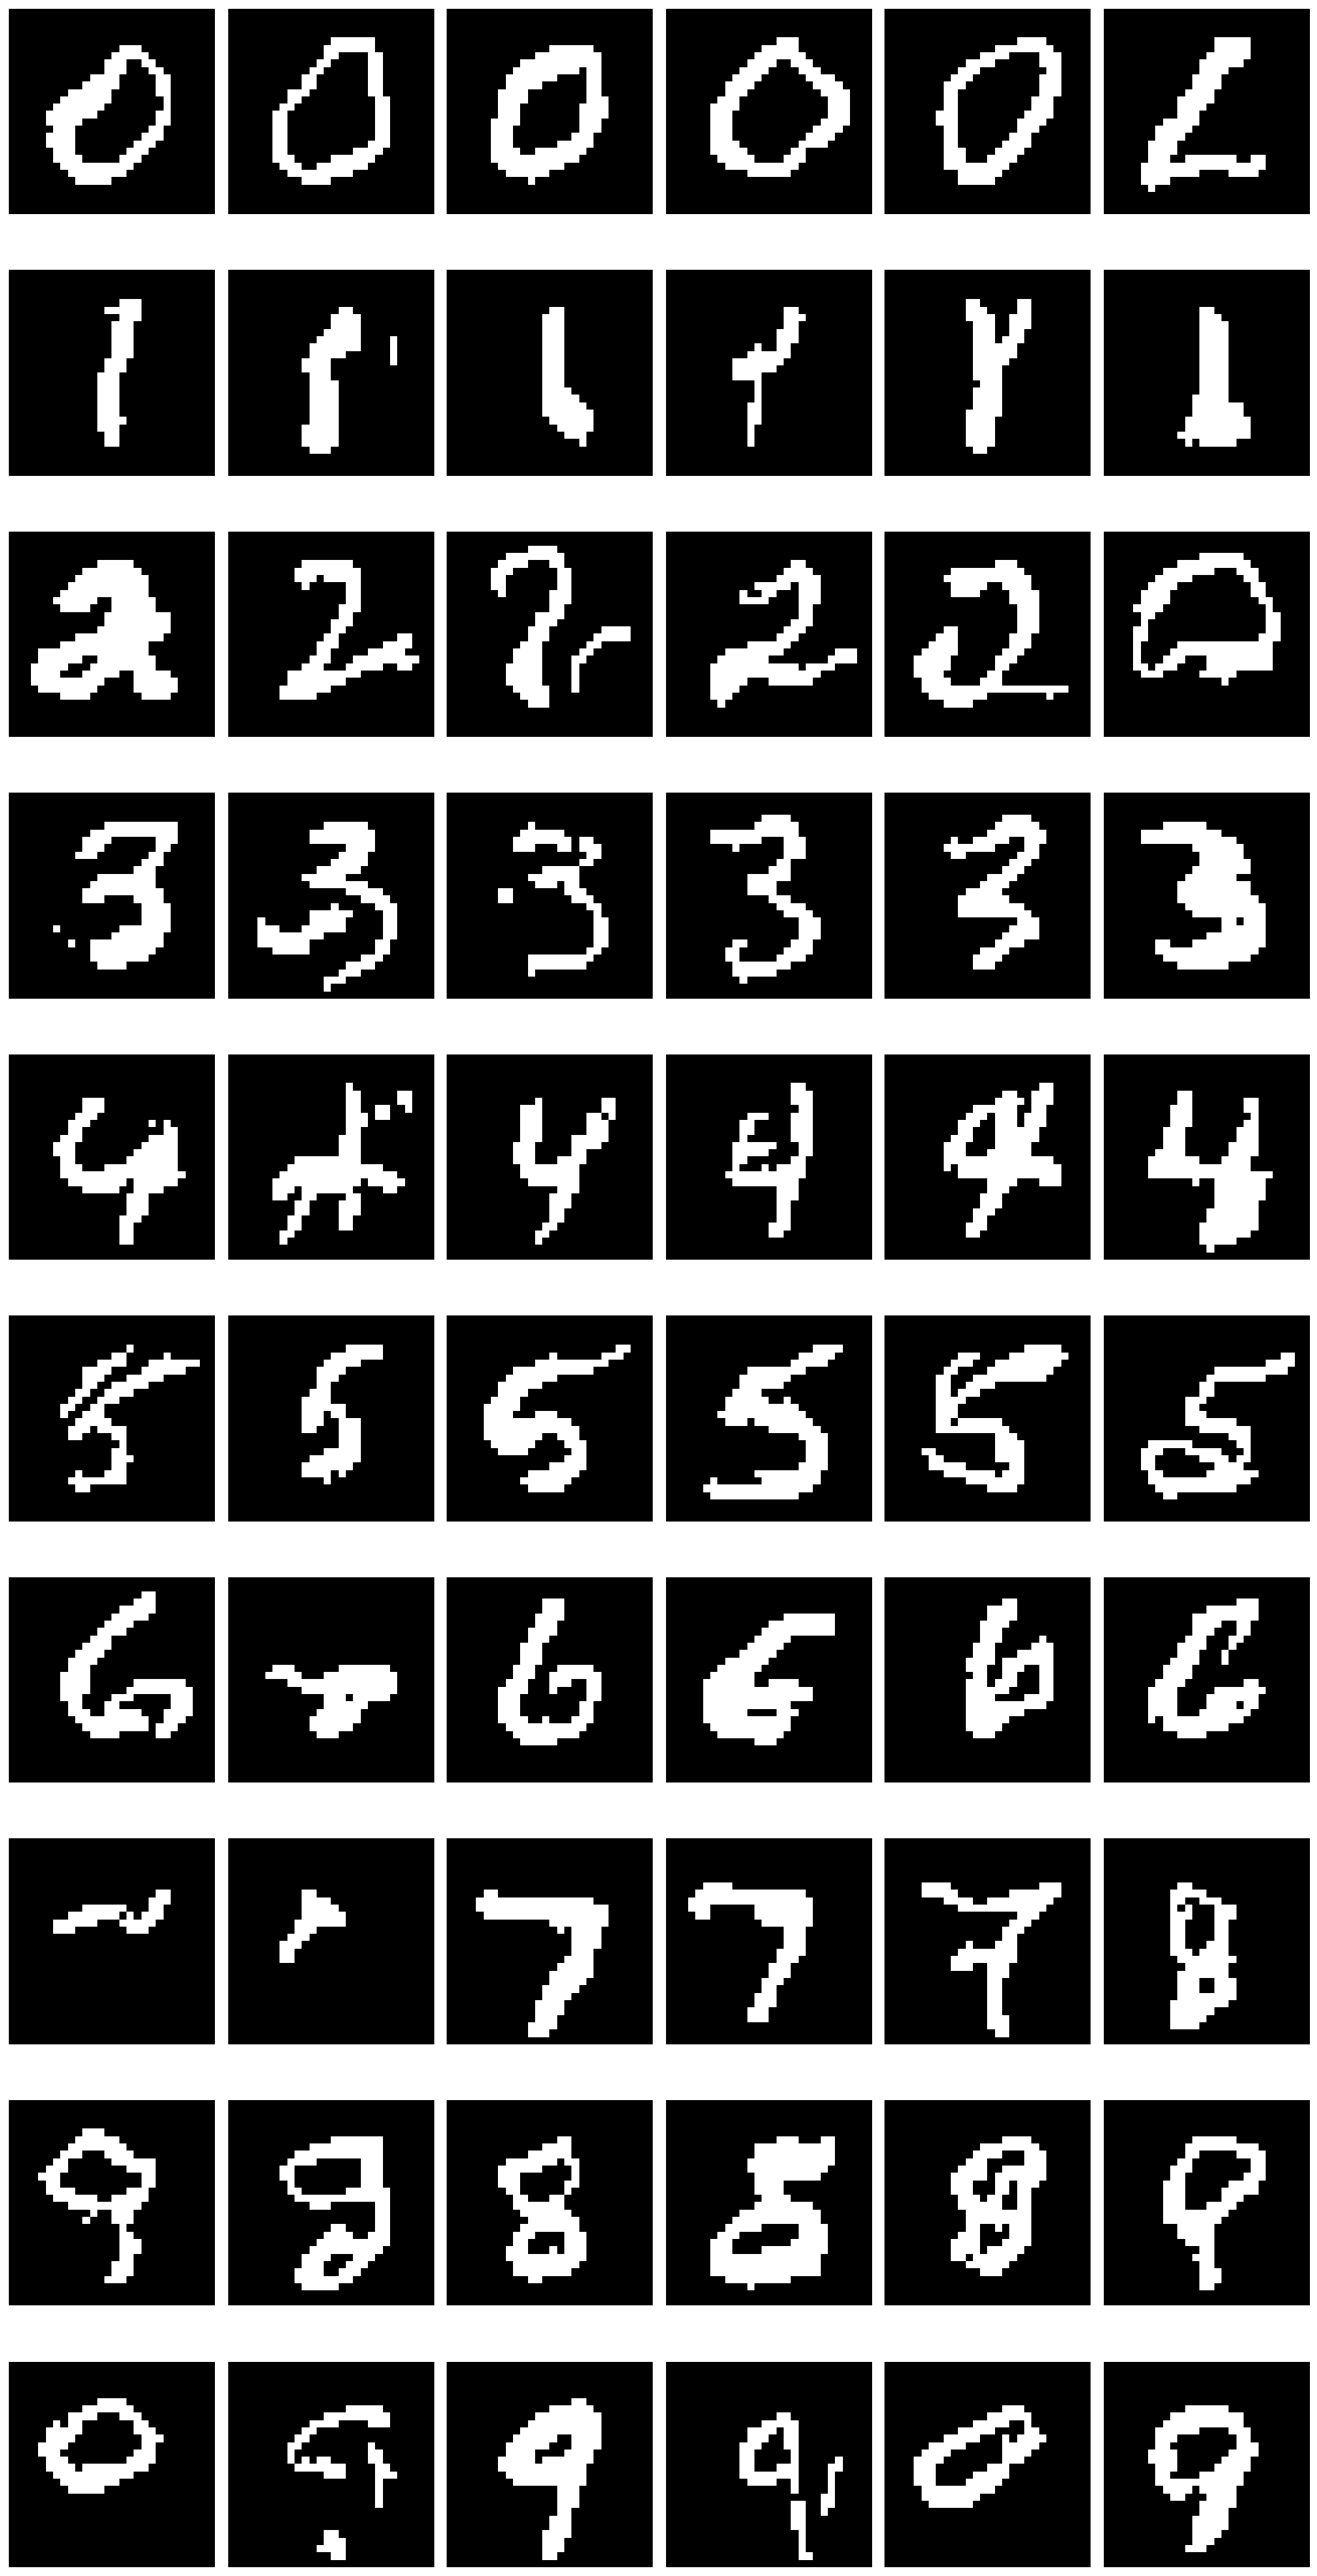

In [80]:
# MY
H, W = 28, 28
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()